# Load data

In [4]:
steam = pd.read_csv('data/steam-200k.csv', header=None, names=['user', 'game', 'purchase_play', 'hrs', 'tmp'])
steam.drop('tmp', inplace=True, axis=1)

steam.info()
steam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user           200000 non-null  int64  
 1   game           200000 non-null  object 
 2   purchase_play  200000 non-null  object 
 3   hrs            200000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.1+ MB


,user,game,purchase_play,hrs
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


# Format data

In [5]:
steam_clean = steam.copy()
steam_clean['purchase'] = steam_clean['purchase_play'] == 'purchase'
steam_clean['purchase'] = steam_clean['purchase'].astype(int)
steam_clean['play'] = steam_clean['purchase_play'] == 'play'
steam_clean['play'] = steam_clean['play'].astype(int)
steam_clean['hrs'] = steam_clean['hrs'] - steam_clean['purchase']
steam_clean = steam_clean.groupby(by=['user', 'game']).agg({'hrs': 'sum', 'purchase': 'sum', 'play': 'sum'}).reset_index()

steam_clean.info()
steam_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128804 entries, 0 to 128803
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      128804 non-null  int64  
 1   game      128804 non-null  object 
 2   hrs       128804 non-null  float64
 3   purchase  128804 non-null  int32  
 4   play      128804 non-null  int32  
dtypes: float64(1), int32(2), int64(1), object(1)
memory usage: 3.9+ MB


,user,game,hrs,purchase,play
0,5250,Alien Swarm,4.9,1,1
1,5250,Cities Skylines,144.0,1,1
2,5250,Counter-Strike,0.0,1,0
3,5250,Counter-Strike Source,0.0,1,0
4,5250,Day of Defeat,0.0,1,0


In [6]:
# Kiểm tra giá trị thiếu trong mỗi cột
missing_values = steam_clean.isna().sum()

# Hiển thị kết quả
print(missing_values)

user        0
game        0
hrs         0
purchase    0
play        0
dtype: int64


# Lọc data

Steam cho phép người dùng hoàn tiền cho những trò chơi họ đã chơi dưới 2 giờ. Chúng tôi quyết định xem xét thực tế này cho hệ thống gợi ý của mình. Do đó, các tương tác giữa người dùng và mục có thời gian dưới 2 giờ sẽ không được xem xét.

In [7]:
steam_play = steam_clean[(steam_clean['play'] == 1) & (steam_clean['hrs'] > 2.0)][['user', 'game', 'hrs']]

steam_play.info()
steam_play.head()
#steam_play.to_csv('data/raw_data/steam_users_play.csv',index=None)

<class 'pandas.core.frame.DataFrame'>
Index: 44925 entries, 0 to 128799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    44925 non-null  int64  
 1   game    44925 non-null  object 
 2   hrs     44925 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4+ MB


,user,game,hrs
0,5250,Alien Swarm,4.9
1,5250,Cities Skylines,144.0
6,5250,Deus Ex Human Revolution,62.0
17,5250,Portal 2,13.6
21,76767,Age of Empires II HD Edition,13.1


## Lọc ra những trò chơi có ít nhất 200 người chơi

In [9]:
# Lọc ra những trò chơi có ít nhất 50 người chơi
games_with_50_users_or_more = steam_play['game'].value_counts()[steam_play['game'].value_counts() >= 50].index

# Lọc dữ liệu cho những trò chơi đó
stream_filtered = steam_play[steam_play['game'].isin(games_with_50_users_or_more)].reset_index(drop=True)

# Hiển thị kết quả
print(stream_filtered)
print(stream_filtered['game'].nunique())

            user                          game    hrs
0           5250                   Alien Swarm    4.9
1           5250               Cities Skylines  144.0
2           5250      Deus Ex Human Revolution   62.0
3           5250                      Portal 2   13.6
4          76767  Age of Empires II HD Edition   13.1
...          ...                           ...    ...
28454  309213952                        Dota 2   13.8
28455  309216884                        Dota 2    4.0
28456  309404240               Team Fortress 2    2.2
28457  309404240                      Unturned   13.0
28458  309626088  Age of Empires II HD Edition    6.7

[28459 rows x 3 columns]
182


# Gán nhãn

Chúng tôi tạo hệ thống xếp hạng dựa trên sự phân bổ số giờ chơi, hệ thống này cho mỗi trò chơi có sẵn trong tập dữ liệu người dùng. Chúng tôi sử dụng 5 nhóm (tương đương với hệ thống xếp hạng 5 sao) để xác định xếp hạng mà người dùng sẽ đưa ra cho trò chơi họ đã chơi dựa trên số giờ mỗi người chơi mỗi trò chơi so với số giờ của những người khác.

In [10]:
def range_5_stars(data, column_name):
    bins = [2.0, 4.0, 8.0, 12.0, 24.0, float('inf')]
    labels = [1.0, 2.0, 3.0, 4.0, 5.0]
    data[column_name + "_range"] = pd.cut(data[column_name], bins=bins, labels=labels).astype('float64')
    return data

C:\Users\Hl10a\AppData\Local\Temp\ipykernel_772\1746775476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



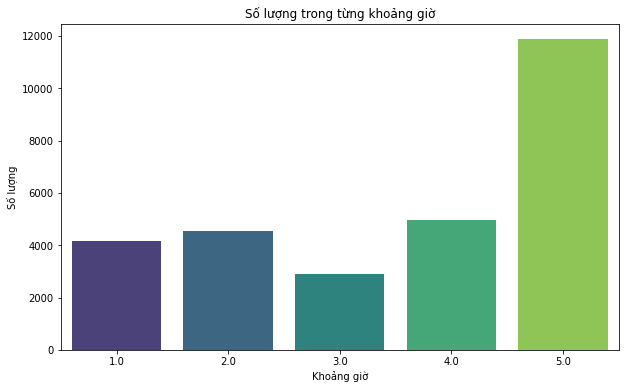

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28459 entries, 0 to 28458
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user       28459 non-null  int64  
 1   game       28459 non-null  object 
 2   hrs        28459 non-null  float64
 3   hrs_range  28459 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 889.5+ KB


,user,game,hrs,hrs_range
0,5250,Alien Swarm,4.9,2.0
1,5250,Cities Skylines,144.0,5.0
2,5250,Deus Ex Human Revolution,62.0,5.0
3,5250,Portal 2,13.6,4.0
4,76767,Age of Empires II HD Edition,13.1,4.0


In [11]:
steam_hrs = stream_filtered.copy()

# Chia số giờ chơi thành các khoảng
steam_hrs = range_5_stars(steam_hrs, "hrs")

# Đếm số lượng trong từng khoảng giờ
hour_counts = steam_hrs['hrs_range'].value_counts()
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="viridis")
plt.title("Số lượng trong từng khoảng giờ")
plt.xlabel("Khoảng giờ")
plt.ylabel("Số lượng")
plt.show()

steam_hrs.info()
steam_hrs.head()

In [12]:
games = pd.DataFrame({'game': np.sort(steam_hrs['game'].unique())})
# Gộp thông tin người chơi và trò chơi vào dataframe chính
steam_game_id = pd.merge(steam_hrs, games, on='game')
steam_game_id.head()

,user,game,hrs,hrs_range,game_id
0,5250,Alien Swarm,4.9,2.0,7
1,975449,Alien Swarm,9.8,3.0,7
2,1950243,Alien Swarm,3.8,1.0,7
3,2259650,Alien Swarm,3.2,1.0,7
4,2753525,Alien Swarm,3.2,1.0,7


In [13]:
unique_games = steam_game_id.drop_duplicates(subset='game_id')[['game', 'game_id']]
unique_games

,game,game_id
0,Alien Swarm,7
150,Cities Skylines,43
249,Deus Ex Human Revolution,62
351,Portal 2,130
738,Age of Empires II HD Edition,4
...,...,...
28097,Trove,174
28224,The Mighty Quest For Epic Loot,160
28275,Just Cause 2 Multiplayer Mod,99
28328,Warface,177


In [14]:

# Tạo ma trận user-game
user_game_matrix = steam_hrs.pivot_table(index='user', columns='game_id', values='hrs_range', fill_value=0)

# Tính độ tương đồng game-game
game_similarity_matrix = cosine_similarity(user_game_matrix.T)

In [17]:
def recommend_item_item(user_game_matrix, user_id):
    user_games = user_game_matrix.loc[user_id]  # Số giờ chơi của người dùng đang xem xét
    # Chuyển ma trận tương đồng thành DataFrame để dễ quan sát
    game_similarity_df = pd.DataFrame(game_similarity_matrix, index=user_game_matrix.columns, columns=user_game_matrix.columns)

    # Tính toán dự đoán số giờ chơi cho các trò chơi người dùng chưa chơi
    predicted_hours = user_games[user_games == 0]  # Chọn những trò chơi người dùng chưa chơi
    rating_user = user_games[user_games != 0]

    for game_id_pre, hours_pre in predicted_hours.items():

        numerator = 0
        denominator = 0
        for game_id, hours in rating_user.items():
            numerator = numerator + game_similarity_df.loc[game_id_pre, game_id] * user_games[game_id]
            denominator = denominator + abs(game_similarity_df.loc[game_id_pre, game_id])

            
        if denominator != 0:
            predicted_hours[game_id_pre] = numerator / denominator  # Dự đoán số giờ chơi
            
    top_predicted_hours = predicted_hours.sort_values(ascending=False).head()

    # Merging top_predicted_hours with steam_game_id based on the common column 'game_id'
    result = pd.merge(top_predicted_hours, unique_games, how='inner', on='game_id')

    return result

In [20]:
user_id = 76767

result = recommend_item_item(user_game_matrix, user_id)

# Displaying the result
print(f"Những game đang có của user_id {user_id}:")
print(steam_game_id[steam_game_id["user"]==user_id]["game"])

print(f"\nNhững game được đề xuất cho user_id {user_id}:")
print(result["game"])

Những game đang có của user_id 76767:
352                                        Portal 2
738                    Age of Empires II HD Edition
901                                        Banished
968                          Call of Duty Black Ops
1153           Call of Duty Black Ops - Multiplayer
1314                  Call of Duty Modern Warfare 2
1570    Call of Duty Modern Warfare 2 - Multiplayer
1821                  Call of Duty Modern Warfare 3
1997    Call of Duty Modern Warfare 3 - Multiplayer
2159                      Call of Duty World at War
2221                                 Counter-Strike
2611                Counter-Strike Global Offensive
3869                          Counter-Strike Source
Name: game, dtype: object

Những game được đề xuất cho user_id 76767:
0    Counter-Strike Condition Zero
1            Medieval II Total War
2                      Left 4 Dead
3           Half-Life 2 Deathmatch
4          Half-Life 2 Episode One
Name: game, dtype: object
